# Forecast Use of a City Bikeshare System

In [76]:
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.metrics import precision_score
import statsmodels.api as sm
%matplotlib inline

### Data Preparation
Data source: https://www.kaggle.com/c/bike-sharing-demand/data

In [3]:
train_df = pd.read_csv("../data/train.csv", parse_dates='datetime', index_col='datetime')
test_df = pd.read_csv("../data/test.csv", parse_dates='datetime', index_col='datetime')

print "Shape of train and test datasets provided by Kaggle:"
print train_df.shape, test_df.shape 

Shape of train and test datasets provided by Kaggle:
(10886, 11) (6493, 8)


In [4]:
train_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32


In [57]:
test_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


Note that the testing dataset Kaggle provides doesn't include 'casual' and 'registered' counts. Thus, we cannot use them in our models. The models will be developed with the training dataset only, and the out-of-sample predictions are made on the testing dataset and submitted to Kaggle.

### Exploratory Data Analysis
#### Univariate Analysis
We first look at individual variables' summary statistics and distributions.

In [45]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


array([[<matplotlib.axes.AxesSubplot object at 0x6e593d0>,
        <matplotlib.axes.AxesSubplot object at 0x9d2cf10>]], dtype=object)

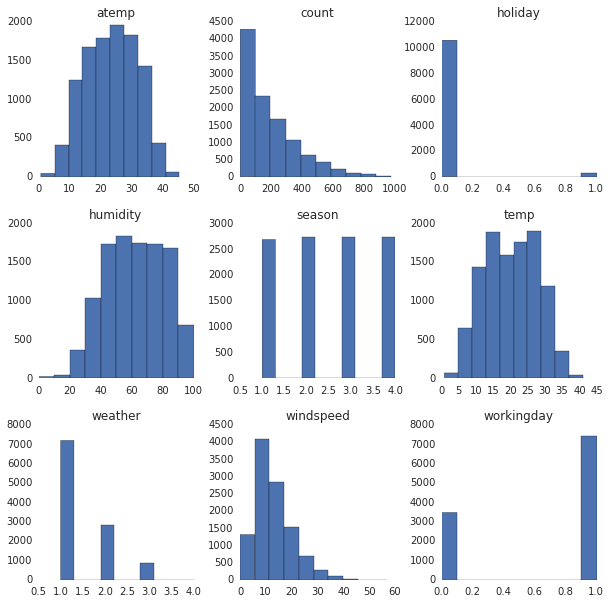

In [49]:
train_df[['season', 'holiday', 'workingday', 'weather','temp','atemp','humidity','windspeed',\
          'count']].hist(sharex=False, sharey=False, figsize=(10,10))

A few takeaways by looking at the summary statistics and historams of all variables.
1. The 'count' variable is heavily skewed to the right. It might be attempting to do a log or sqrt transformation on the variable. However, this research (http://onlinelibrary.wiley.com/doi/10.1111/j.2041-210X.2010.00021.x/abstract;jsessionid=6995BE35A675ED557554C982A6E8FEB3.d04t01?systemMessage=Wiley+Online+Library+will+be+disrupted+on+25+August+from+13%3A00-15%3A00+BST+%2808%3A00-10%3A00+EDT%29+for+essential+maintenance&userIsAuthenticated=false&deniedAccessCustomisedMessage=) shows that performing log-transformation is not as good as using models based on Poisson and negative binomial distributions.
2. Only a very small amount of data are from holidays. This is expected but we do need to pay close attention to these data points as they might be potential outliers.
3. Data points are evenly distributed among four seasons.
4. The 'weather' variable shows that extreme weathers are rare. Again this is expected but we need to look out for outlier days.
5. Windspeed is slightly right-skewed. It doesn't seem to be severe enough to require a transformation but we want to keep an eye on the far right potential outliers.

##### Now let's plot the five continuous variables over time.

array([<matplotlib.axes.AxesSubplot object at 0x94cd110>,
       <matplotlib.axes.AxesSubplot object at 0xac8e710>], dtype=object)

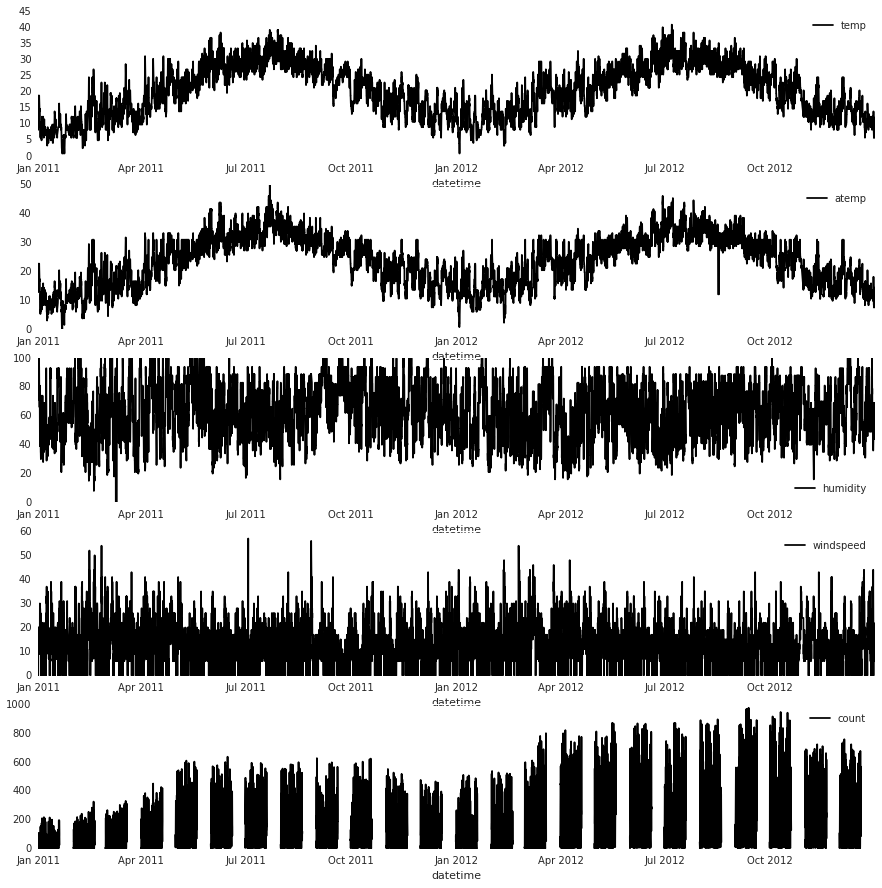

In [50]:
df[['temp','atemp','humidity','windspeed','count']]\
    .plot(subplots=True, sharex=False, sharey=False, figsize=(15,15))

'temp, 'atemp', and 'count' variables show clear seasonal patterns. We will try decomposite the seasonality in the time series analysis section.

#### Bivariate Analysis
Now let's look at relationships between variables.

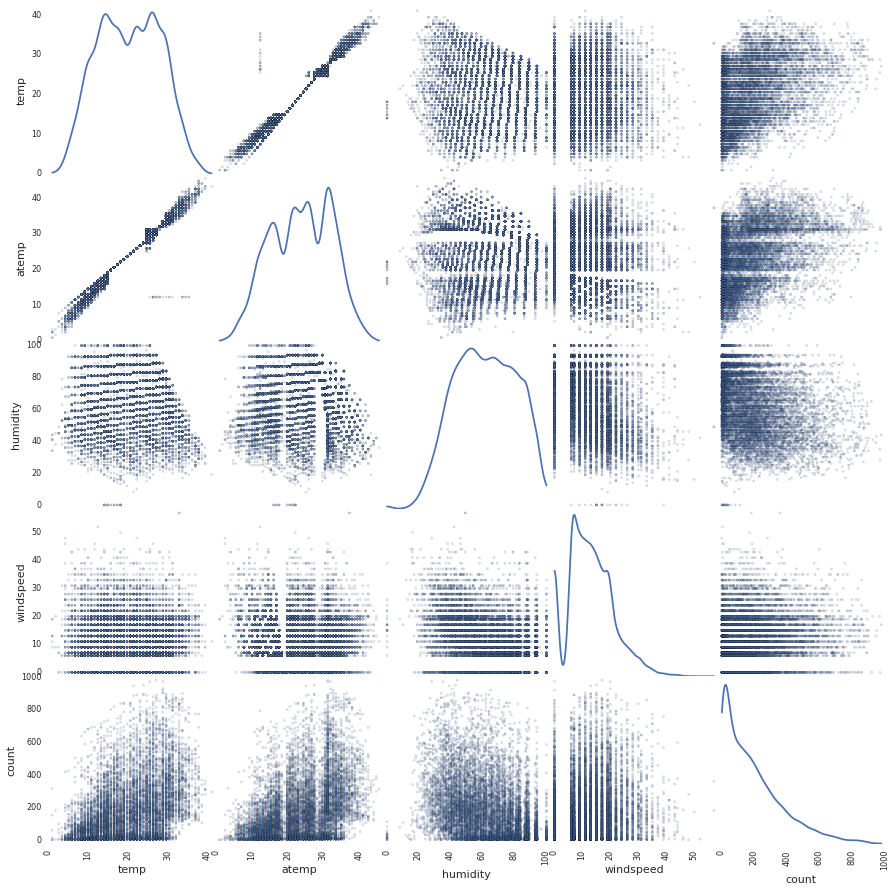

In [21]:
axes = pd.tools.plotting.scatter_matrix(df[['temp','atemp','humidity','windspeed','count']], \
                                        alpha=0.2, figsize=(15, 15), diagonal='kde')

The pair-wise plots indicate:
1. 'temp' and 'atemp' are very strongly correlated and might cause multi-colinearity issues to our models.
2. There seems to be a positive relationship between 'temp'/'atemp' and 'count'.

### OLS Linear Regression
#### Baseline Model
To construct a baseline model, we use every available variables in the dataset and run a simple linear regression.

In [214]:
train_feat = np.asarray(train_df[['season','holiday','workingday','weather','temp','atemp',\
                        'humidity','windspeed']])
train_targ = np.asarray(train_df[['count']])

lr = LinearRegression(fit_intercept=True)
lr.fit(train_feat, train_targ)

print 'Baseline linear regression model summary:'
print 'Coefficients: \n', lr.coef_
print 'R-squared: %.2f' % lr.score(train_feat, train_targ)

Baseline linear regression model summary:
Coefficients: 
[[ 22.75882041  -9.15872365  -1.14953067   5.93871831   1.84736842
    5.63120253  -3.05683516   0.77761604]]
R-squared: 0.26


#### Cross Validation and Root Mean Squared Logarithmic Error (RMSLE)
We perform 5-fold cross validation on the training dataset and aggregate results across the folds to avoid overfitting.

Kaggle evaluates models using the Root Mean Squared Logarithmic Error (RMSLE). https://www.kaggle.com/c/bike-sharing-demand/details/evaluation
We also uses it as our main evaluation measure. In addition, we look at model R-squared.

In [199]:
# Function to calculate Root Mean Squared Logarithmic Error
def get_RMSLE(n, p, a):
    s = 0.0
    for i in range(len(p)):
        s += pow((np.log(p[i] + 1) - np.log(a[i] + 1)), 2)
    rmsle = pow((s/n), 0.5)
    return rmsle

In [310]:
# Function to iterate through the training and testing cross validation segments and
# run linear regression on each one, aggregating the results
def k_fold_cv(feat, targ, k):
    cv = KFold(len(targ), n_folds=k)
    lr = LinearRegression(fit_intercept=True)

    rsqs = []
    rmsles = []
    precisions = []
    for traincv, testcv in cv:
        lr.fit(feat[traincv,], targ[traincv])
        preds = lr.predict(feat[testcv,])
        # eliminate negative predictions
        preds[preds < 0] = 0
        # counts can only be integer
        preds = np.round(np.transpose(preds)[0])
        
        rsqs.append( lr.score(feat[traincv,], targ[traincv]) )
        rmsles.append( get_RMSLE(len(preds), preds, np.transpose(targ[testcv])[0]) )
    
    return rsqs, rmsles

In [311]:
rsqs, rmsles = k_fold_cv(train_feat, train_targ, 5)

print '----- 5-fold baseline model results -----'
print 'Mean Rsq: %.2f' % np.mean(rsqs)
print 'All Rsqs: ', rsqs
print 'Mean RMSLE: %.2f' % np.mean(rmsles)
print 'All RMSLEs: ', rmsles

----- 5-fold baseline model results -----
Mean Rsq: 0.26
All Rsqs:  [0.22986895663631945, 0.2964933380548147, 0.26581108220910465, 0.25512747302599759, 0.27554255334990319]
Mean RMSLE: 1.47
All RMSLEs:  [1.6568171644378231, 1.4869136127557316, 1.6568109429200637, 1.3032814524107412, 1.2358046443251316]


#### Feature Selection
First, let's examine the potential colinearity issue by removing 'temp' or 'atemp' from the model.

After removing 'temp', the mean Rsq increases 0.01 and the mean RMSLE drops 0.01. We determine that removing 'temp' gives us a better model.

In [313]:
# remove atemp from the baseline model
train_feat = np.asarray(train_df[['season','holiday','workingday','weather','temp',\
                                'humidity','windspeed']])

rsqs, rmsles = k_fold_cv(train_feat, train_targ, 5)
print '----- removing atemp -----'
print 'Mean Rsq: %.2f' % np.array(rsqs).mean()
print 'All Rsqs: ', rsqs
print 'Mean RMSLE: %.2f' % np.array(rmsles).mean()
print 'All RMSLEs: ', rmsles

# remove temp from the baseline model
train_feat = np.array(train_df[['season','holiday','workingday','weather','atemp',\
                                'humidity','windspeed']])

rsqs, rmsles = k_fold_cv(train_feat, train_targ, 5)
print '\n----- removing temp -----'
print 'Mean Rsq: %.2f' % np.array(rsqs).mean()
print 'All Rsqs: ', rsqs
print 'Mean RMSLE: %.2f' % np.array(rmsles).mean()
print 'All RMSLEs: ', rmsles

----- removing atemp -----
Mean Rsq: 0.26
All Rsqs:  [0.22986895663631945, 0.2964933380548147, 0.26581108220910465, 0.25512747302599759, 0.27554255334990319]
Mean RMSLE: 1.47
All RMSLEs:  [1.6568171644378231, 1.4869136127557316, 1.6568109429200637, 1.3032814524107412, 1.2358046443251316]

----- removing temp -----
Mean Rsq: 0.27
All Rsqs:  [0.23268454579932729, 0.29549817599733641, 0.26755956515259571, 0.25585067272636519, 0.2788319866571306]
Mean RMSLE: 1.46
All RMSLEs:  [1.6618210137275367, 1.4749838615439044, 1.6462406063033321, 1.3023002453091344, 1.2332959303842224]


#### Model Diagnostics and Outlier Examination

#### Seasonality Decomposition

### Generalized Linear Model

### Generalized Boosted Regression